In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os, re, json, pickle
from collections import defaultdict


In [2]:
# make imports work
import sys
sys.path.insert(0, "/Users/JonathanHeitz/git/dementia/src/")


## Define some functions

For reading of data and analysis 

In [3]:
from config.config import Config
from dataloader.dataset import Dataset

def get_features(results_dir):
    """
    Get information from a result directory
    Returns
    - df: Dataset used, including samples_names, feature values for all features, labels
    - gini_importance_scores: Feature importance scores according to Gini index in Random Forest
    - ASR_name
    """
    base_dir = '/Volumes/methlab/Students/Jonathan/results/runs'

    d = os.path.join(base_dir, results_dir)
    yaml_file = [f for f in os.listdir(d) if f.endswith(".yaml")][0]
    config = Config.from_yaml(os.path.join(d, yaml_file))

    preprocessors = "+".join(config.preprocessors).replace("Linguistic Features Literature", "LinguFL").replace("Other Model Prediction", "BERT").replace("Automatic Punctuation", "Punct").replace("Audio Features", "AudioF")

    asr_preprocessor = [p for p in config.preprocessors if 'ASR' in p]
    asr_name = asr_preprocessor[0].replace("ASR ", "") if len(asr_preprocessor) > 0 else None

    timestamp = re.findall(r"[0-9]{8}_[0-9]{4}", d)[-1]
    date = re.findall(r"[0-9]{8}", d)[-1]

    data = config.data.replace("ADReSS_audio", "ADR").replace("ADReSS_with_PITT_audio", "ADR_PITT").replace("ADReSS_manual_transcripts", "manual")
    model = config.model.replace("RandomForest", "RandFor").replace("GradientBoosting", "GB").replace("BERT_NEW","BERT").replace("LogisticRegression", "LogReg")

    parameter_string = f"{data} {preprocessors} {model} {timestamp}"

    with open(os.path.join(d, "gini_feature_importance.txt"), "r") as f:
        gini_importance_scores = json.load(f)
        gini_importance_scores = {feature_name: importance_score for feature_name, importance_score in gini_importance_scores}

    dataset = Dataset.from_disk(os.path.join(d, 'dataset'))
    df = dataset.data
    df['label'] = dataset.labels
    df['sample_name'] = dataset.sample_names
    return df, gini_importance_scores, asr_name


def feature_group_mapping(feature_name):
    if feature_name in ['pronoun_noun_ratio', 'verb_noun_ratio', 'subordinate_coordinate_conjunction_ratio', 'adverb_ratio', 'noun_ratio', 'verb_ratio', 'pronoun_ratio', 'personal_pronoun_ratio', 'determiner_ratio', 'preposition_ratio', 'verb_present_participle_ratio', 'verb_modal_ratio', 'verb_third_person_singular_ratio', 'propositional_density', 'content_density']:
        return "Syntactic / POS", feature_name, r"SYN/P"
    elif feature_name in ['NP -> PRP', 'ADVP -> RB', 'NP -> DT_NN', 'ROOT -> FRAG', 'VP -> VBG', 'VP -> VBG_PP', 'VP -> VBD_NP', 'INTJ -> UH', 'NP_ratio', 'PRP_ratio', 'PP_ratio', 'VP_ratio', 'avg_n_words_in_NP']:
        return "Syntactic / Constituents", feature_name, r"SYN/C"
    elif feature_name in ['n_words', 'n_unique_words', 'avg_word_length', 'avg_sentence_length', 'words_not_in_dict_ratio', 'brunets_index', 'honores_statistic', 'ttr', 'mattr', 'flesch_kincaid']:
        return "Lexical", feature_name, "LEX"
    elif feature_name in ['avg_distance_between_utterances', 'prop_utterance_dist_below_05']:
        return "Semantic / Repetitiveness", feature_name, "REP"
    else:
        print("Missing group", feature_name)
        return feature_name, feature_name, "-"


/Users/jheitz/miniconda3/envs/dementia/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data collection and analysis for each ASR

Let's read the results of our prediction runs from disk.

Then, we compare how transcripts and corresponding features behave for each ASR system individually, for each ASR system

In [4]:
manual_run = "2023_kw38/20230920_1510_e1ff_overview/20230920_1518_linguistic_features_literature_cdcp"

asr_runs = {
    'whisper': '2023_kw38/20230920_1510_e1ff_overview/20230920_1528_ling_feat_lit_whisper_PAR_only_caft',
    'google_speech': "2023_kw38/20230920_1510_e1ff_overview/20230920_1522_ling_feat_lit_google_speech_PAR_only_cjsr",
    'wave2vec2': '2023_kw38/20230920_1510_e1ff_overview/20230920_1525_ling_feat_lit_wave2vec2_PAR_only_vrni'
}
asr_names = list(asr_runs.keys())


abs_mean_rel_diff = {}
mean_normalized_group_diff = {}
data_combined = {}
groupwise_feature_diff = {}

# load data of manual run 
data_manual, feature_importance_manual, _ = get_features(manual_run)

# calculate group difference for manual transcripts
#mean_normalized_group_diff_manual = plot_distribution_group_difference(
#    data_manual.query("label == 1").drop(columns=['label', 'sample_name']),
#    data_manual.query("label == 0").drop(columns=['label', 'sample_name']),
#    data_manual.drop(columns=['label', 'sample_name']), f"manual transcripts")
#mean_normalized_group_diff["manual"] = mean_normalized_group_diff_manual
data_combined['manual'] = data_manual

for i, asr_name in enumerate(asr_runs):
    asr_run = asr_runs[asr_name]
    
    # load data of asr run
    data_asr, feature_importance_asr, asr_name = get_features(asr_run)
    data_combined[asr_name] = data_asr

    # calculate group difference for ASR transcript = Feature effect size θ
    #mean_normalized_group_diff_here = plot_distribution_group_difference(
    #    data_asr.query("label == 1").drop(columns=['label', 'sample_name']),
    #    data_asr.query("label == 0").drop(columns=['label', 'sample_name']),
    #    data_asr.drop(columns=['label', 'sample_name']), f"{asr_name} transcripts")
    #mean_normalized_group_diff[asr_name] = mean_normalized_group_diff_here

    # Distribution of the relative difference between manual and ASR transcripts 
    #abs_mean_rel_diff_here, groupwise_feature_diff_here = difference_sample_wise_and_feature_importance(data_manual, data_asr, "manual", asr_name, mean_normalized_group_diff_manual, mean_normalized_group_diff_here)
    #abs_mean_rel_diff[asr_name] = abs_mean_rel_diff_here
    #groupwise_feature_diff[asr_name] = groupwise_feature_diff_here


Created object of class <class 'dataloader.dataset.TabularDataset'>: Dataset Concatenate(ADReSS manual transcripts (train) - Linguistic Features (Literature), ADReSS manual transcripts (test) - Linguistic Features (Literature)) with variables [('data', (156, 40)), ('sample_names', (156,)), ('labels', (156,))], config ({'preprocessors': ['Linguistic Features (Literature)'], 'debug': False, 'cv_shuffler': <dataloader.cv_shuffler.ADReSSCrossValidationShuffler object at 0x150d33580>, 'transcript_config': {'only_PAR': True, 'keep_pauses': False, 'keep_terminators': True, 'keep_unintelligable_speech': False}, 'transcript_config_hash': '4f7384'})
Created object of class <class 'dataloader.dataset.TabularDataset'>: Dataset Concatenate(ADReSS audio (train) - Audio Cutter - whisper-large transcribed - Linguistic Features (Literature), ADReSS audio (test) - Audio Cutter - whisper-large transcribed - Linguistic Features (Literature)) with variables [('data', (156, 40)), ('sample_names', (156,)), (

## Combine results of different ASR systems

## Let's create our big overview plot 

A: Distribution of the relative difference $d_{j,i,k}$ between manual and ASR transcripts, for each feature and each ASR system. Features are sorted according to their stability  $s_j$ (subfigure B). We display the feature group for each feature (syntactic features based on POS tags \texttt{SYN/P}, syntactic features based on grammatical constituents \texttt{SYN/C}, lexical features \texttt{LEX}, and features of repetitiveness \texttt{REP}). Example: The most unstable feature is the lexical (LEX) feature flesch_kincaid, the Flesch–Kincaid grade level, which is a combination of the number of words in a sentence and the number of syllables in a word. All ASR transcripts produce higher values of this feature than manual transcripts. This is caused by longer sentences produces by ASR compared to manual transcriptions. B: $s_j$, the stability of a feature across all ASR systems. Lower means more stable. C: Feature importance given by mean absolute SHAP value, based on the trained RF classifier, for manual transcripts and for each ASR. Dark-green indicates high feature importance, white indicates low feature importance. 

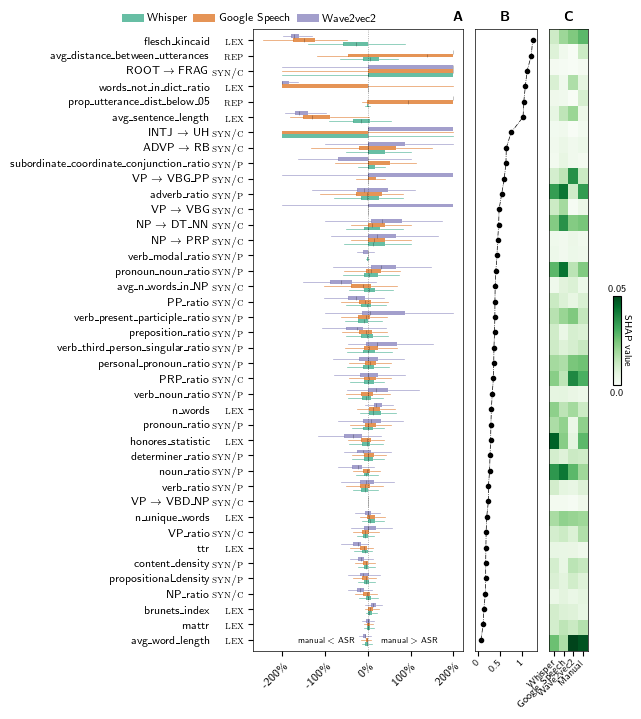

In [5]:
import pickle

def calculate_mean_relative_difference_per_feature(features_group1, features_group2):
    # Feature effect size θ
    assert list(features_group1.columns) == list(features_group2.columns)
    feature_names = [f for f in list(features_group1.columns) if f not in ['label', 'sample_name']]

    relative_difference = {}
    for f in feature_names:
        comp = features_group1[['sample_name',f]].merge(features_group2[['sample_name',f]], on="sample_name", how="inner")
        comp['diff'] = comp[f'{f}_x'] - comp[f'{f}_y']
        mean_existing_value = (comp[f'{f}_x'] + comp[f'{f}_y']) / 2
        comp['relative_difference'] =  np.where(mean_existing_value != 0, comp['diff'] / mean_existing_value, 0)
        relative_difference[f] = comp['relative_difference']

    return pd.DataFrame(relative_difference)

def calculate_mean_group_difference_per_feature(features_dementia, features_control, all_features):
    feature_names = all_features.columns

    mean = all_features.mean(axis=0)
    std = all_features.std(axis=0)

    # normalized values
    dementia_normalized = (features_dementia - mean)/std
    control_normalized = (features_control - mean)/std

    # diff per feature
    diff = dementia_normalized.mean() - control_normalized.mean()
    diff_sorted = diff.sort_values(key=abs, ascending=False)

    # return mean normalized difference per feature
    return diff_sorted

def difference_sample_wise_and_group_difference_combined(data_combined):
    
    data_manual = data_combined['manual']
    feature_names = [f for f in list(data_manual.columns) if f not in ['label', 'sample_name']]
    asr_names = [k for k in data_combined.keys() if k != 'manual']
    asr_name_cleaned = lambda asr: asr.replace("whisper", "Whisper").replace("google_speech", "Google Speech").replace("wave2vec2", "Wave2vec2")

    # tick positions, for each ASR, depends on number of ASR systems 
    block_size = len(asr_names) + 1
    tick_positions = pd.DataFrame({asr: [i * block_size + asr_idx + 1 for i in range(len(feature_names))] for asr_idx, asr in enumerate(asr_names)})
    tick_positions['label'] = [i * block_size + block_size/2 for i in range(len(feature_names))]

    boxplot_colors = { 'whisper': "#1B9E77aa", 'google_speech': "#D95F02aa", 'wave2vec2': "#7570B3aa",}

    # get feature importance
    with open("feature_importance_overview.pkl", "rb") as f:
        feature_importance = pickle.load(f)

    # get relative difference between manual and asr
    relative_differences = {}
    mean_abs_relative_difference = {}
    for asr in asr_names:
        # calculate the relative difference for each sample for each feature between manual and asr: d_{j,i,k} according to paper
        relative_differences[asr] = calculate_mean_relative_difference_per_feature(data_manual, data_combined[asr])
        # also the mean relative difference for each feature, over all samples
        mean_abs_relative_difference[asr] = relative_differences[asr].abs().mean()

    # sort the features according to how much is a feature different between manual and asr,
    # averaged over all asr systems => abs mean of mean_relative_difference
    mean_abs_relative_difference_df = pd.DataFrame.from_dict(mean_abs_relative_difference)
    mean_of_abs_mean_relative_difference = mean_abs_relative_difference_df.mean(axis=1)
    features_sorted = list(mean_of_abs_mean_relative_difference.sort_values(ascending=True).index)

    relative_differences_sorted = {asr: [relative_differences[asr][f] for f in features_sorted] for asr in asr_names}

    # get group difference (feature effect size θ) between dementia and control
    mean_normalized_group_diff = {}
    for version in asr_names + ['manual']:
        mean_normalized_group_diff[version] = calculate_mean_group_difference_per_feature(
            data_combined[version].query("label == 1").drop(columns=['label', 'sample_name']),
            data_combined[version].query("label == 0").drop(columns=['label', 'sample_name']),
            data_combined[version].drop(columns=['label', 'sample_name']))

    # plotting parameters to create a pdf plot matching the dimension of the LREC submission
    with plt.rc_context({"text.usetex": True, "font.family": "sans-serif", "font.size": 10, "lines.linewidth": 0.5}):
        # one column is 7.7 cm, entire page is 16cm
        cm = 1/2.54
        #fig, (ax, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16*cm, len(feature_names)/2*cm), gridspec_kw={'width_ratios': [5,1,1,1]})
        fig = plt.figure(constrained_layout=False, figsize=(16*cm, len(feature_names)/2.2*cm))
        padding_top = 0.05
        padding_bottom = 0.08
        gs1 = fig.add_gridspec(1, 4, left=0.4, right=0.85, wspace=0.2, top=1-padding_top, bottom=padding_bottom)#width_ratios=[1,1,1,1,1,1,0.3], wspace=0.1)
        ax = fig.add_subplot(gs1[:,:3])
        ax1 = fig.add_subplot(gs1[:,3])

        gs2 = fig.add_gridspec(1, 1, left=0.85, right=0.95, top=1-padding_top, bottom=padding_bottom, wspace=-0.2)#width_ratios=[1,1,1,1,1,1,0.3], wspace=0.1)
        ax3 = fig.add_subplot(gs2[:,:])

        gs3 = fig.add_gridspec(5, 4, left=0.97, right=1, top=1-padding_top, bottom=padding_bottom, hspace=0.5)#width_ratios=[1,1,1,1,1,1,0.3], wspace=0.1)
        ax4b = fig.add_subplot(gs3[2,:3])
        ax5b = fig.add_subplot(gs3[2,3])


        ax.set_title(r'\textbf{A}', fontsize=10, pad=6, loc="right")
        ax1.set_title(r'\textbf{B}', fontsize=10, pad=6)
        ax3.set_title(r'\textbf{C}', fontsize=10, pad=6)

        ax.text(-0.3, 1, r"manual $<$ ASR", fontsize=6, fontstyle="italic", ha='right') # max(tick_positions['label'])+3
        ax.text(0.3, 1, r"manual $>$ ASR", fontsize=6, fontstyle="italic", ha='left') # max(tick_positions['label'])+3
        boxes = []
        for asr in asr_names:
            box = ax.boxplot(relative_differences_sorted[asr], vert=False, sym="", positions=tick_positions[asr], showmeans=False,
                             meanline=False, patch_artist=True, widths=1, showcaps=False,
                             boxprops=dict(facecolor=boxplot_colors[asr], edgecolor=(0, 0, 0, 0), linewidth=0.5),
                             whiskerprops=dict(color=boxplot_colors[asr], linewidth=0.5), medianprops=dict(linewidth=0.5, color="#0005"))
            boxes.append(box)
        ax.legend([b['boxes'][0] for b in boxes], [asr_name_cleaned(asr) for asr in asr_names],
                  fontsize=8, ncol=3, loc='upper center', bbox_to_anchor=(-0.02, 1.04),#(0.22,1.04),
                  columnspacing=0.5, frameon=False, handletextpad=0.3, markerscale=0.4)

        # make space at top for potential text
        ax.set_ylim(-1, block_size*len(feature_names)+1)

        # set space between axis and yticks
        ax.tick_params(axis='y', which='major', pad=28)

        def transformed_feature_name(feature_name):
            feature_name = f"{feature_name[:len(feature_name)//2]}{feature_name[len(feature_name)//2:]}" if len(feature_name) > 20 else feature_name
            return feature_name.replace("->", r"$\rightarrow$")
        ax.set_yticks(tick_positions['label'], [fr"{transformed_feature_name(feature_name)}" for feature_name in features_sorted], linespacing=0.7, fontsize=8, wrap=True)

        # set feature group names next to yticks
        for ypos, feature_name in zip(tick_positions['label'], features_sorted):
            ax.text(-2.9, ypos, rf"\textsc{{{feature_group_mapping(feature_name)[2].lower()}}}", ha="right", va="center_baseline", fontsize=8)

        xtick_positions = [-2, -1, 0, 1, 2]
        ax.set_xticks(xtick_positions, [f'{t*100}\%' for t in xtick_positions], rotation=45, ha='right', rotation_mode='anchor', fontsize=8)
        ax.axvline(0, linestyle=":", color="k", alpha=0.5, linewidth=0.5)


        ax1.plot(mean_of_abs_mean_relative_difference.sort_values(ascending=True), tick_positions['label'], linestyle="-.", color="k", marker=".")
        ax1.set_yticks([])
        ax1.set_ylim(-1, block_size*len(feature_names)+1)
        ax1.set_xlim(-0.05, 1.35)
        
        xticks = [0, 0.5, 1]
        ax1.set_xticks(xticks, xticks, rotation=45, ha='right', va="center", rotation_mode='anchor', fontsize=7)


        feature_importance_sorted = feature_importance.reindex(features_sorted)
        feature_importance_sorted = feature_importance_sorted[['Whisper Linguistic', "GoogleSpeech Linguistic", 'Wave2vec2 Linguistic', "Manual Linguistic"]].rename(columns={'GoogleSpeech Linguistic': 'Google Speech Linguistic'})
        c2 = ax3.imshow(feature_importance_sorted.values, cmap='Greens', aspect=1.6, origin='lower', vmin=0, vmax=0.05)
        ax3.set_yticks([])
        #ax3.set_yticks(range(len(feature_importance_sorted.index)), feature_importance_sorted.index)
        ax3.set_xticks(range(len(feature_importance_sorted.columns)), [c.replace(" Linguistic","") for c in feature_importance_sorted.columns], rotation=45, ha='right', va="center", rotation_mode='anchor', fontsize=7)
        #ax3.set_xlabel("SHAP feature importance")

        cb2 = fig.colorbar(c2, ax=ax4b, fraction=1, pad=0.01, aspect=10, panchor=False, orientation="vertical", ticks=[])#ticks=[0, 0.05])
        ax4b.axis("off")
        cb2.ax.tick_params(labelsize=7)

        # make color ticks top and bottom
        cb2.ax.text(0.5, -0.05, f"{cb2.vmin:.1f}", transform=cb2.ax.transAxes, va='top', ha='center', fontsize=7)
        cb2.ax.text(0.5, 1.03, f"{cb2.vmax:.2f}", transform=cb2.ax.transAxes, va='bottom', ha='center', fontsize=7)

        ax5b.text(0,0.5,r"SHAP value", rotation=-90, va='center', ha='center', fontsize=7)
        ax5b.axis("off")

        for axis in ['top','bottom','left','right']:
            for a in [ax, ax3, ax1, ax4b]:
                a.spines[axis].set_linewidth(0.5)


        #plt.tight_layout()
        plt.savefig(f"plots/diff_linguistic_feature_values_manual_vs_asr_combined_fullpage_with_feature_importance_colorbars2_no_effect_size.pdf")
        plt.show()

        return 



difference_sample_wise_and_group_difference_combined(data_combined)